In [1]:
%matplotlib inline
from pylab import *
rcParams['figure.figsize'] = (9, 6)  # Figure size for inline display
import numpy as np
import timeit

In [2]:
from pynx.wavefront import *

if False:
    # The following is only using on multi-GPU, multi-user (e.g. Amazon) machines
    # Select a device number (0..15) to avoid resource conflict with other participants
    from pynx.processing_unit.cuda_device import has_cuda
    if has_cuda:
        from pynx.processing_unit.cuda_device import cu_drv
        default_processing_unit_wavefront.init_cuda(cu_device=cu_drv.Device(0))
    else:
        import pyopencl as cl
        from pynx.wavefront.cl_operator import FreePU, PropagateNearField, PropagateFarField, PropagateFRT, default_processing_unit_wavefront
        # Only useful to select GPu on multiple-GPU machines (e.g. Amazon EC2)
        default_processing_unit_wavefront.init_cl(cl_device=cl.get_platforms()[1].get_devices()[0])

gpyfft version: 0.7.0


Searching available OpenCL GPU[ranking by fft, fft_shape=(16, 400, 400)]:
                                            Iris Pro [Apple]: 1536Mb [max alloc.: 384Mb],  22.26 Gflop/s
                  AMD Radeon R9 M370X Compute Engine [Apple]: 2048Mb [max alloc.: 512Mb],  73.48 Gflop/s
Using OpenCL GPU: AMD Radeon R9 M370X Compute Engine


/Users/favre/dev/py35-env/lib/python3.5/site-packages/pyopencl/cffi_cl.py:1502: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  "to see more.", CompilerWarning)


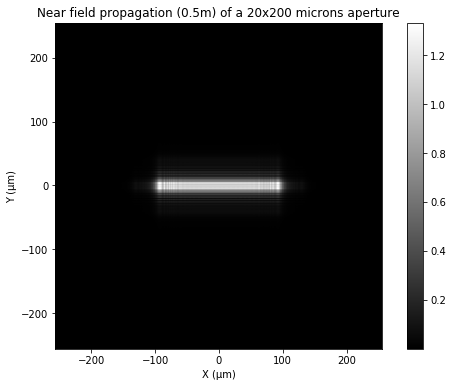

In [3]:
# Near field propagation of a simple 20x200 microns slit
w = Wavefront(d=np.zeros((512, 512), dtype=np.complex64), pixel_size=1e-6, wavelength=1.5e-10)
a = 20e-6 / 2
x, y = w.get_x_y()
w.set((abs(y) < a) * (abs(x) < 100e-6))
w = PropagateNearField(0.5) * w
w = ImshowAbs(fig_num=1,title="Near field propagation (0.5m) of a 20x200 microns aperture") * w

<IPython.core.display.Javascript object>


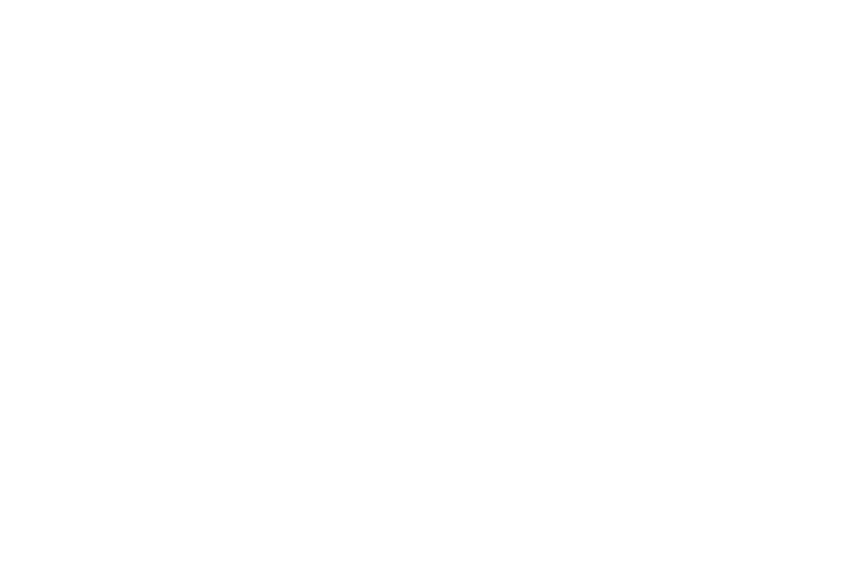

/Users/favre/dev/py35-env/lib/python3.5/site-packages/matplotlib/backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)
/Users/favre/dev/py35-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


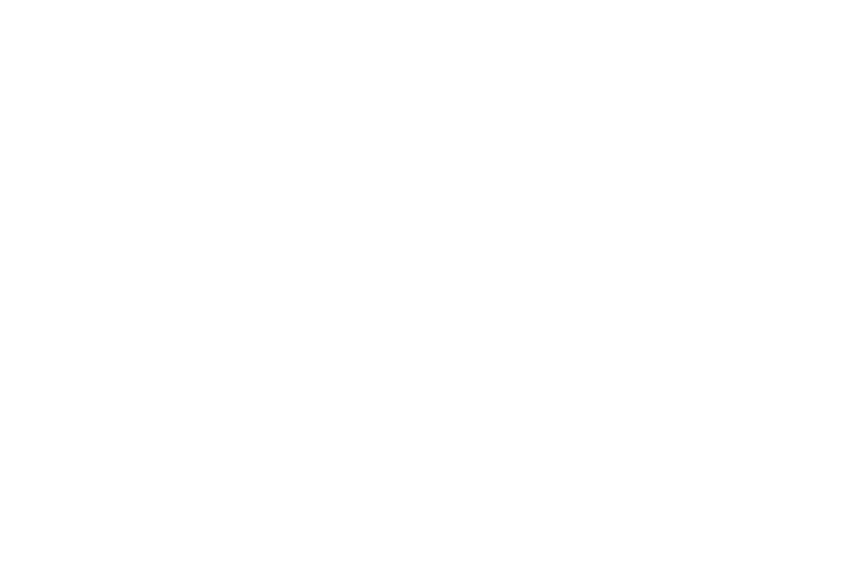

In [4]:
# Activate live display
%matplotlib notebook
# Near field propagation of a simple 40x200 microns slit, displaying the propagated wavefront by steps
# of 0.2 m propagation
w = Wavefront(d=np.zeros((512, 512), dtype=np.complex64), pixel_size=1e-6, wavelength=1.5e-10)
a = 40e-6 / 2
x, y = w.get_x_y()
w.set((abs(y) < a) * (abs(x) < 100e-6))
# Perform 15 near field propagation of 0.2m steps, displaying the complex wavefront each time
# the **15 expression allows to repeat the series of operators 15 times.
w = (ImshowRGBA(fig_num=1) * PropagateNearField(0.2))**15 * w


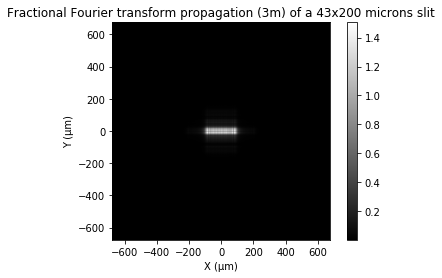

In [5]:
#Fractional Fourier transform propagation (3m) of a 43x200 microns slit
%matplotlib inline
w = Wavefront(d=np.zeros((1024, 1024), dtype=np.complex64), pixel_size=1.3e-6, wavelength=1.e-10)
a = 43e-6 / 2
x, y = w.get_x_y()
w.set((abs(y) < a) * (abs(x) < 100e-6))
# w = FromPU() * PropagateNearField(3) * w
w = PropagateFRT(3) * w
# w = FromPU() * PropagateFarField(20) * w
# w = FromPU() * PropagateNearField(-3) * PropagateNearField(3) * w
# w = FromPU() * PropagateFRT(3, forward=False) * PropagateFRT(3) * w
# w = FromPU() * PropagateFarField(100, forward=False) * PropagateFarField(100) * w
w = ImshowAbs(title="Fractional Fourier transform propagation (3m) of a 43x200 microns slit") * w

a= 22.0um, dark spot at a^2/(2pi*lambda)= 0.77m, I[0]= 1.42
a= 43.0um, dark spot at a^2/(2pi*lambda)= 2.94m, I[0]= 0.70
a= 88.0um, dark spot at a^2/(2pi*lambda)=12.32m, I[0]= 1.09
a=142.0um, dark spot at a^2/(2pi*lambda)=32.09m, I[0]= 1.20
a=182.0um, dark spot at a^2/(2pi*lambda)=52.72m, I[0]= 1.03


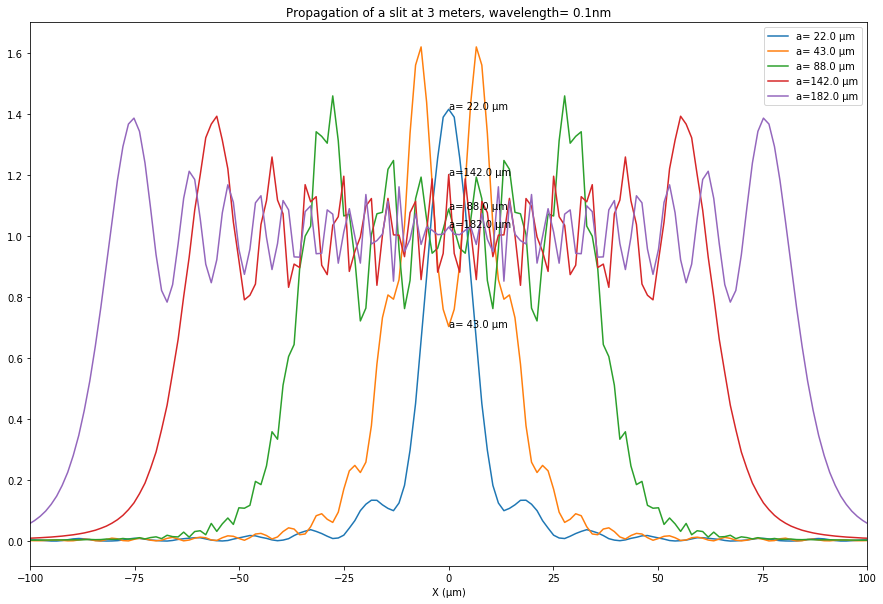

In [6]:
# Jacques et al 2012 single slit setup - here with simulated 1 micron pixel
# Compare with figure 7 for a=43,88,142,82 microns
figure(figsize=(15, 10))
for a in np.array([22, 43, 88, 142, 182]) * 1e-6 / 2:
    w = Wavefront(d=np.zeros((1024, 1024), dtype=np.complex64), wavelength=1e-10, pixel_size=1.3e-6)
    x, y = w.get_x_y()
    d = w.get()
    d[:] = (abs(y) < (a)).astype(np.complex64)
    w.set(d)
    # w = PropagateNearField(3) * w
    w = PropagateFRT(3) * w
    # w = PropagateFarField(3) * w
    icalc = np.fft.fftshift(abs(w.get())).mean(axis=1) ** 2
    x, y = w.get_x_y()
    plot(np.fft.fftshift(y) * 1e6, icalc, label='a=%5.1f µm' % (a * 2e6))
    text(0, icalc[len(icalc) // 2], 'a=%5.1f µm' % (a * 2e6))
    print('a=%5.1fum, dark spot at a^2/(2pi*lambda)=%5.2fm, I[0]=%5.2f' % (
        2 * a * 1e6, (2 * a) ** 2 / (2 * pi * w.wavelength), icalc[len(icalc) // 2]))
title("Propagation of a slit at 3 meters, wavelength= 0.1nm")
legend()
xlim(-100, 100)
xlabel('X (µm)')

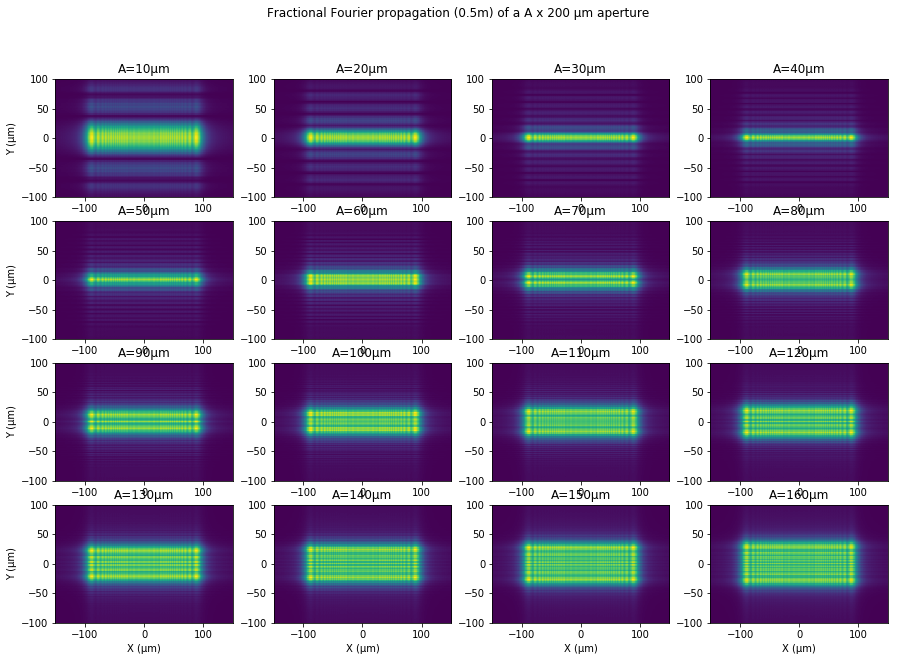

In [7]:
# propagation of a stack of A x 200 microns apertures, varying A
w = Wavefront(d=np.zeros((16, 512, 512), dtype=np.complex64), pixel_size=1e-6, wavelength=1.5e-10)
x, y = w.get_x_y()
d = w.get()
for i in range(16):
    a = 5e-6 / 2 * (i + 1)
    d[i] = ((abs(y) < a) * (abs(x) < 100e-6)).astype(np.complex64)
w.set(d)
w = PropagateFRT(1.2) * w
figure(figsize=(15, 10))
x, y = w.get_x_y()
x *= 1e6
y *= 1e6
for i in range(16):
    subplot(4, 4, i + 1)
    imshow(abs(fftshift(w.get()[i])), extent=(x.min(), x.max(), y.min(), y.max()), origin='lower')
    title("A=%dµm" % (10 * (i + 1)))
    if i >= 12:
        xlabel('X (µm)')
    if i % 4 == 0:
        ylabel('Y (µm)')
    xlim(-150, 150)
    ylim(-100, 100)
suptitle("Fractional Fourier propagation (0.5m) of a A x 200 µm aperture")


In [8]:
# Time propagation of stacks of 1024x1024 wavefronts
for nz in [1, 1, 10, 50, 100, 200]:  # First size is repeated to avoid counting initializations
    t0 = timeit.default_timer()
    w = Wavefront(d=np.zeros((nz, 512, 512), dtype=np.complex64), pixel_size=1e-6, wavelength=1.5e-10)
    x, y = w.get_x_y()
    a = 20e-6 / 2
    d=w.get()
    print("####################### Stack size: %4d x %4d *%4d ################" % d.shape)
    d[:] = ((abs(y) < a) * (abs(x) < 100e-6)).astype(np.complex64)
    w.set(d)
    t1 = timeit.default_timer()
    print("%30s: dt=%6.2fms" % ("Wavefront creation (CPU)", (t1 - t0) * 1000))
    w = PropagateFRT(1.2) * w
    default_processing_unit_wavefront.synchronize()  # Make sure calculations are finished
    t2 = timeit.default_timer()
    print("%30s: dt=%6.2fms" % ("Copy to GPU + Propagation", (t2 - t1) * 1000))
    w = PropagateFRT(1.2) * w
    default_processing_unit_wavefront.synchronize()  # Make sure calculations are finished
    t3 = timeit.default_timer()
    print("%30s: dt=%6.2fms" % ("Propagation", (t3 - t2) * 1000))
    junk = w.get()  # We use FreeFromPU() to make sure we release GPU memory
    t4 = timeit.default_timer()
    print("%30s: dt=%6.2fms" % ("Copy from GPU", (t4 - t3) * 1000))

####################### Stack size:    1 x  512 * 512 ################
      Wavefront creation (CPU): dt= 24.84ms
     Copy to GPU + Propagation: dt=  6.26ms
                   Propagation: dt=  1.17ms
                 Copy from GPU: dt=  1.59ms
####################### Stack size:    1 x  512 * 512 ################
      Wavefront creation (CPU): dt= 12.66ms
     Copy to GPU + Propagation: dt=  2.07ms
                   Propagation: dt=  0.88ms
                 Copy from GPU: dt=  2.25ms
####################### Stack size:   10 x  512 * 512 ################
      Wavefront creation (CPU): dt= 73.11ms
     Copy to GPU + Propagation: dt= 18.96ms
                   Propagation: dt=  3.38ms
                 Copy from GPU: dt= 16.48ms
####################### Stack size:   50 x  512 * 512 ################
      Wavefront creation (CPU): dt=344.99ms
     Copy to GPU + Propagation: dt= 63.06ms
                   Propagation: dt= 15.63ms
                 Copy from GPU: dt= 75.79ms
############

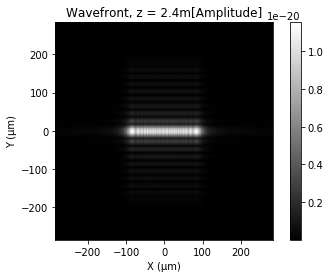

In [9]:
# Display one wavefront (i=..) in the stack
ImshowAbs(i=1)*w

Number of modes in the probe: 3


/Users/vincent/dev/py35-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


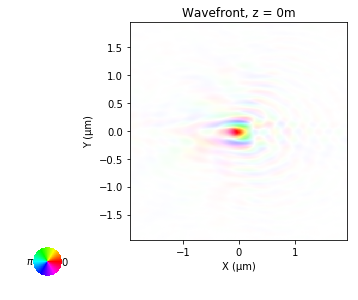

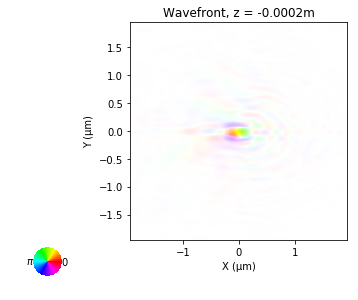

In [10]:
# Load one wavefront from a previous ptychography experiment, propagate all modes
d = np.load('data/201606id01-FZP-S0013-result.npz')
w = Wavefront(d=np.fft.fftshift(d['probe']), pixel_size=d['pixelsize'], wavelength=1.5e-10)
print("Number of modes in the probe:", len(w.get()))
figure()
w = ImshowRGBA(i=1) * w  # For some reason in this file the strongest mode is #1
figure()
w = ImshowRGBA(i=1) * PropagateNearField(-200e-6) * w

<IPython.core.display.Javascript object>


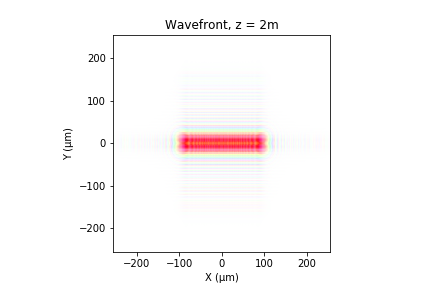

/Users/vincent/dev/py35-env/lib/python3.5/site-packages/matplotlib/backend_bases.py:2453: MatplotlibDeprecationWarning: Using default event loop until function specific to this GUI is implemented
  warnings.warn(str, mplDeprecation)
/Users/vincent/dev/py35-env/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


<IPython.core.display.Javascript object>


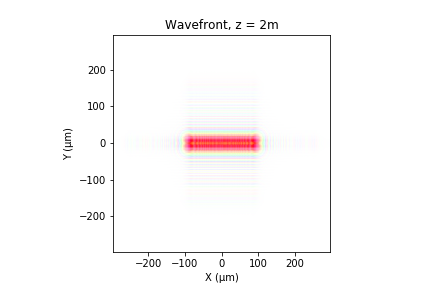

<IPython.core.display.Javascript object>


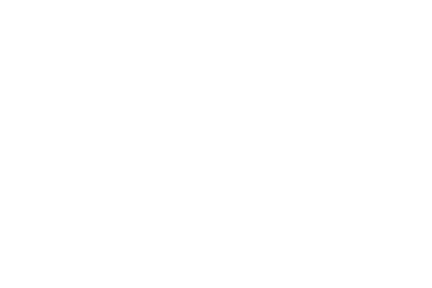

<IPython.core.display.Javascript object>


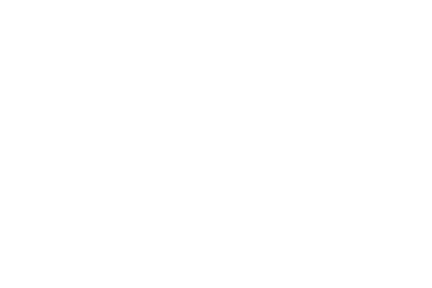

In [11]:
# Activate live display
%matplotlib notebook
# Near field propagation of a simple 40x200 microns slit, displaying the propagated wavefront by steps
# of 0.2 m propagation
w = Wavefront(d=np.zeros((512, 512), dtype=np.complex64), pixel_size=1e-6, wavelength=1.5e-10)
a = 40e-6 / 2
x, y = w.get_x_y()
w.set((abs(y) < a) * (abs(x) < 100e-6))
# Perform 15 near field propagation of 0.2m steps, displaying the complex wavefront each time
# the **15 expression allows to repeat the series of operators 15 times.
w = ImshowRGBA(fig_num=1) * PropagateNearField(2) * w

w = Wavefront(d=np.zeros((512, 512), dtype=np.complex64), pixel_size=1e-6, wavelength=1.5e-10)
w.set((abs(y) < a) * (abs(x) < 100e-6))
# Perform 15 near field propagation of 0.2m steps, displaying the complex wavefront each time
# the **15 expression allows to repeat the series of operators 15 times.
w = ImshowRGBA(fig_num=2) * PropagateFRT(2) * w